<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/03-ml-housing-prediction/RealEstateAI_PricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RealEstateAI Solutions - predictive model for real estate pricing

> 👨‍💻 Developed as part of the **AI Engineering Master – Week 2**

### This project aims to build a predictive model for real estate pricing using linear regression techniques with regularization. The objective is to improve model generalization, reduce overfitting, and offer robust, accurate pricing estimates using Ridge, Lasso, and Elastic Net regressions.

## Key Goals:
- Load and preprocess the housing dataset
- Handle missing values and categorical variables
- Scale features for regularization methods
- Train Ridge, Lasso, and Elastic Net models
- Evaluate models using Cross-Validation and MSE
- Compare performance and model sparsity
- Visualize results and residuals

🔗 GitHub Repository:
[📁 ai-portfolio]()


---



## Load and Explore Housing Dataset



In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn and ML tools
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Stats and VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KaggleHub
import kagglehub
from kagglehub import KaggleDatasetAdapter

# **Utilities functions**

### This section contains general-purpose helper functions to support exploratory data analysis, statistical diagnostics, and feature evaluation in machine learning workflows.


In [2]:
def show_correlation_matrix(selected_df: pd.DataFrame) -> None:
    """
    Displays a heatmap of the correlation matrix.
    Args:
        selected_df (pd.DataFrame): DataFrame (usually with numeric columns) for correlation plot.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(selected_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

In [3]:
def calculate_vif(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates Variance Inflation Factor (VIF) for each feature in the DataFrame.
    Identifies multicollinearity where VIF > 5 or 10 indicates potential issue.
    Args:
        df (pd.DataFrame): DataFrame with only numerical features.
    Returns:
        pd.DataFrame: Feature names and respective VIF values, sorted descending.
    """
    vif = pd.DataFrame()
    vif['feature'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif.sort_values(by='VIF', ascending=False)

In [4]:
def evaluate(model, X, y_true):
    """
    Evaluate a linear regression model on provided data, print metrics,
    and return residual standard deviation and residuals.

    Args:
        model: Trained regression model.
        X: Feature matrix.
        y_true: True target vector (log-transformed).

    Returns:
        sigma: Residual standard deviation.
        residuals: Residuals on original scale (y_true_real - y_pred).
    """
    y_pred_log = model.predict(X)
    y_pred = np.exp(y_pred_log)
    y_true_real = np.exp(y_true)
    mse = mean_squared_error(y_true_real, y_pred)
    sigma = residual_std(y_true_real, y_pred, X.shape[1])

    print(f'MSE: {mse:.3f}')
    print(f'RMSE: {np.sqrt(mse):.3f}')
    print(f'R2 SCORE: {r2_score(y_true_real, y_pred):.3f}')

    residuals = y_true_real - y_pred
    return sigma, residuals


In [5]:
def evaluate_best_model(model_name, model, param_grid, X_train, y_train, X_test, y_test):
    """
    Function to perform hyperparameter tuning using GridSearchCV with x-fold CV,
    fit the best model on training data, make predictions, and print evaluation metrics.

    Parameters:
    - model_name: str, name of the model (for printing).
    - model: scikit-learn estimator (e.g., Ridge(), Lasso()).
    - param_grid: dict, hyperparameters grid for GridSearchCV.
    - X_train, y_train: training data features and target.
    - X_test, y_test: test data features and target.

    Returns:
    - best_model: the model instance fitted with the best parameters.
    - y_test_pred: predictions made on test data.
    - test_rmse: RMSE on test data.
    - test_r2: R² score on test data.
    """

    # Initialize GridSearchCV with the model, param grid, and x-fold cross-validation
    grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_

    # Predict in log scale
    y_train_pred_log = best_model.predict(X_train)
    y_test_pred_log = best_model.predict(X_test)

    # Convert predictions and targets back to original scale
    y_train_pred = np.exp(y_train_pred_log)
    y_test_pred = np.exp(y_test_pred_log)
    y_train_real = np.exp(y_train)
    y_test_real = np.exp(y_test)

    # Evaluation Metrics
    train_mse = mean_squared_error(y_train_real, y_train_pred)
    test_mse = mean_squared_error(y_test_real, y_test_pred)

    train_rmse = np.sqrt(train_mse)
    test_rmse  = np.sqrt(test_mse)

    train_r2 = r2_score(y_train_real, y_train_pred)
    test_r2  = r2_score(y_test_real, y_test_pred)

    # Print results
    print(f"{model_name}")
    print(f"Best Params: {grid.best_params_}")

    print(f"Train MSE: {train_mse:.2f}")
    print(f"Test  MSE: {test_mse:.2f}")

    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test  RMSE: {test_rmse:.2f}")

    print(f"Train R²: {train_r2:.3f}")
    print(f"Test  R²: {test_r2:.3f}")

    print(f"Non-zero Coefficients: {(best_model.coef_ != 0).sum()} / {len(best_model.coef_)}\n")

    return best_model, y_test_pred, test_rmse, test_r2


In [6]:
def residual_std(y_true, y_pred, n_features):
    """
    Calculates the residual standard deviation (sigma estimate) for model residuals.

    Args:
        y_true: Actual target values.
        y_pred: Predicted target values.
        n_features: Number of features used in the model.

    Returns:
        sigma_hat: Residual standard deviation estimate.
    """
    n = len(y_true)
    residuals = y_true - y_pred
    sse = np.sum(residuals ** 2)
    sigma_hat = np.sqrt(sse / (n - n_features - 1))
    return sigma_hat

In [7]:
def plot_learning_curve(selected_model, X, y, ax=None, title='Learning Curve'):
    """
    Plots training and validation scores versus training set size to visualize learning curve.

    Args:
        selected_model: Instantiated scikit-learn estimator.
        X: Feature matrix.
        y: Target vector.
        ax: matplotlib axis to plot on (optional).
        title: Title for the subplot.

    Returns:
        None
    """
    from sklearn.model_selection import learning_curve
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Set seaborn theme for consistent plot styling
    sns.set_theme()

    # Get learning curve data
    train_size_abs, train_scores, test_scores = learning_curve(
        selected_model, X, y, cv=5, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 10),
        shuffle=True, random_state=42
    )

    # Use provided axis or default to current one
    if ax is None:
        ax = plt.gca()

    # Plot training and validation scores
    ax.plot(train_size_abs, train_scores.mean(axis=1), label='Train score', marker='o')
    ax.plot(train_size_abs, test_scores.mean(axis=1), label='Test score', marker='o')

    # Add titles and labels
    ax.set_title(title)
    ax.set_xlabel('Training set size')
    ax.set_ylabel('R² score')
    ax.grid(True)
    ax.legend()

    # Ensure border is visible
    ax.set_frame_on(True)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.2)


# Data Loading
---



In [8]:
# Set the path to the file you'd like to load
file_path = 'Housing.csv'

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  'yasserh/housing-prices-dataset',
  file_path,
)

df.head(2)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished


In [9]:
# view summary statistics
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [11]:
df.isna().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [12]:
# Checking for unique values in categorical variables
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f'{col}: {df[col].unique()}')

mainroad: ['yes' 'no']
guestroom: ['no' 'yes']
basement: ['no' 'yes']
hotwaterheating: ['no' 'yes']
airconditioning: ['yes' 'no']
prefarea: ['yes' 'no']
furnishingstatus: ['furnished' 'semi-furnished' 'unfurnished']


In [13]:
# Checking for unbalanced distribution of binary variables
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

for col in binary_cols:
  print(f'{df[col].value_counts()}')

mainroad
yes    468
no      77
Name: count, dtype: int64
guestroom
no     448
yes     97
Name: count, dtype: int64
basement
no     354
yes    191
Name: count, dtype: int64
hotwaterheating
no     520
yes     25
Name: count, dtype: int64
airconditioning
no     373
yes    172
Name: count, dtype: int64
prefarea
no     417
yes    128
Name: count, dtype: int64


## 📊 Dataset Summary

- The dataset contains **545 rows** and **13 columns**
- The dataset includes two main data types: `int64` for numerical features and `object` for categorical ones
- No missing values are present in any column (`df.isna().sum() == 0`)
- All categorical variables are clean and consistent (`yes`/`no`, `furnished` variants)
---




# 🧼 Data Preprocessing

- Encode binary and ordinal categorical variables
- Transform target (`log(price)`) and numerical features (e.g., `sqrt(area)`)
- Split dataset into training and test sets
- Standardize numerical features for regularized regression


In [14]:
# Encode categorical columns (excluding 'furnishingstatus')
categorical_cols_labels = categorical_cols.to_list()
categorical_cols_labels.remove('furnishingstatus')

yes_no_map = {
    'yes': 1,
    'no': 0
}

# Iterate through each categorical column intended for 'yes'/'no' mapping
for col_label in categorical_cols_labels:
    # Check if the column contains only 'yes', 'no', or NaN values
    # Using .isin() checks if all unique values are part of the map keys or are NaN
    # .all() ensures this is true for all elements
    if df[col_label].dropna().isin(yes_no_map.keys()).all():
        df[col_label] = df[col_label].map(yes_no_map)
    else:
        # Optional: Print a warning or log if a column has unexpected values
        print(f"Warning: Column '{col_label}' contains values other than 'yes' or 'no'. Mapping skipped.")

df.head(2)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished


In [15]:
# Ordinal encoding for furnishingstatus
ordinal_map = {
    'unfurnished': 0,
    'semi-furnished': 1,
    'furnished': 2
}

# Check if the 'furnishingstatus' column still contains string values
# that are keys in the ordinal_map.
# df['furnishingstatus'].dropna().astype(str) ensures we compare strings,
# and .isin() checks if all non-NaN values are among the map's keys.
if df['furnishingstatus'].dropna().astype(str).isin(ordinal_map.keys()).all():
    df['furnishingstatus'] = df['furnishingstatus'].map(ordinal_map)
else:
    # Optional: Print a warning or log if the column has already been mapped or contains unexpected values
    print(f"Warning: Column 'furnishingstatus' seems to have been already mapped or contains unexpected values. Mapping skipped.")

df.head(2)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,2
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,2


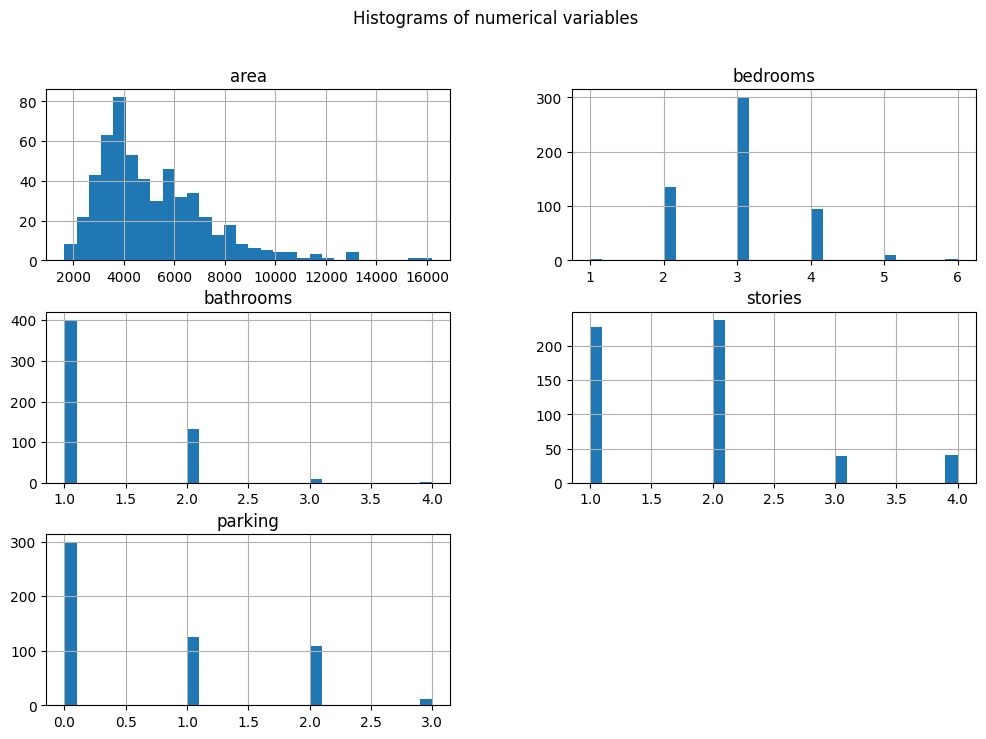

In [16]:
# Histograms of numerical variables
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
df[numeric_vars].hist(bins=30, figsize=(12, 8))
plt.suptitle('Histograms of numerical variables')
plt.show()

### ✅ The histograms display the distribution of several numerical variables:

- Area: The area values are right-skewed, with most properties ranging between approximately 2000 and 7000 square units, but with some larger properties extending beyond 10,000.

- Bedrooms: The majority of homes have 3 bedrooms, followed by 2 and 4 bedrooms. Very few properties have 5 or 6 bedrooms.

- Bathrooms: Most properties have 1 or 2 bathrooms, with very few having 3 or 4.

- Stories: Most homes have either 1 or 2 stories, fewer have 3 or 4 stories, and 3-story homes are the rarest.

- Parking: The majority of properties have no parking, or 1 or 2 parking spaces; a small number have 3.

These distributions give an overview of the characteristics of the dataset, highlighting the frequency and range of values for each property attribute.

# Checking distribution of price and area

## Both prices and area have no 0 or neg values `(df['col_name'] <= 0).sum()`

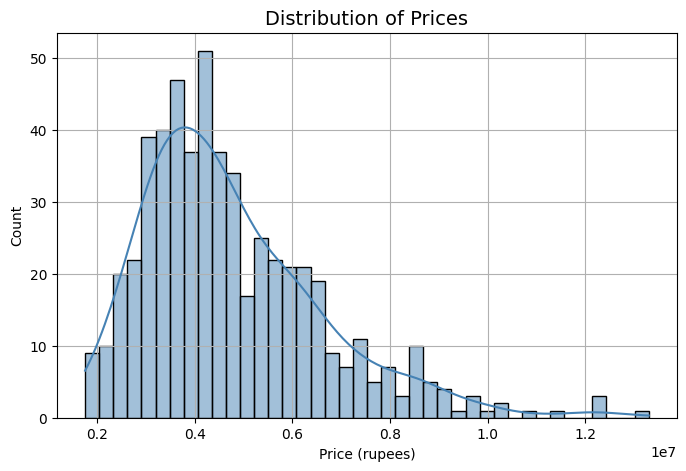

In [17]:
# Distribution of price and area (check for zeros or negatives)
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=40, kde=True, color='steelblue')
plt.title('Distribution of Prices', fontsize=14)
plt.xlabel('Price (rupees)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

### ✅ Price distribution is right-skewed, so we use log transformation to normalize it. Log transform tends to stabilize variance and linearize relationships, which benefits regression models.

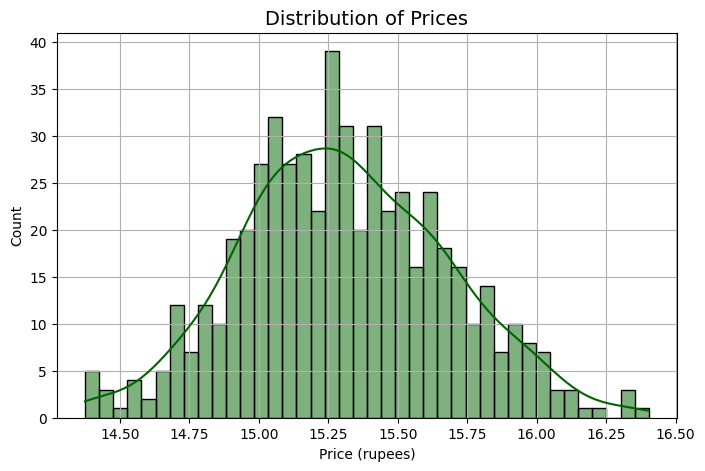

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(np.log(df['price']), bins=40, kde=True, color='darkgreen')
plt.title('Distribution of Prices', fontsize=14)
plt.xlabel('Price (rupees)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Checking AREA

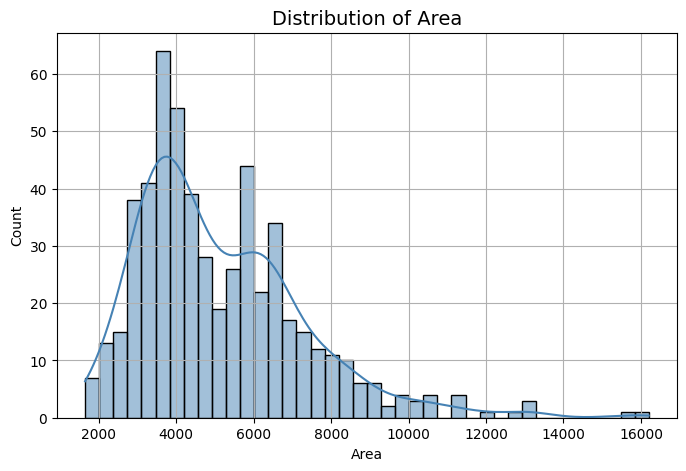

In [19]:
plt.figure(figsize=(8,5))
sns.histplot(df['area'], bins=40, kde=True, color='steelblue')
plt.title('Distribution of Area', fontsize=14)
plt.xlabel('Area')
plt.ylabel('Count')
plt.grid(True)
plt.show()

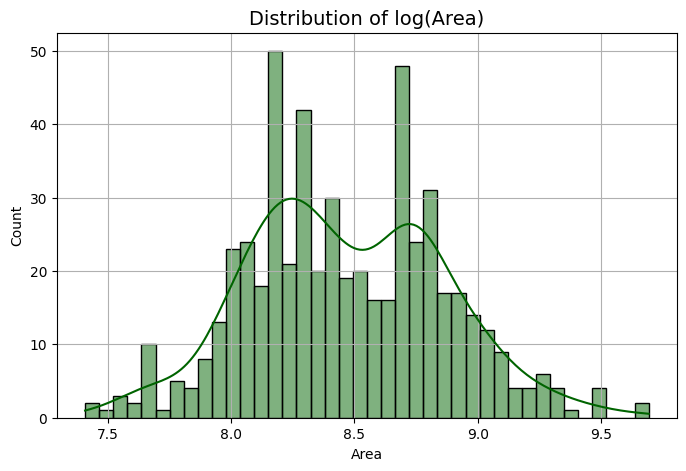

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(np.log(df['area']), bins=40, kde=True, color='darkgreen')
plt.title('Distribution of log(Area)', fontsize=14)
plt.xlabel('Area')
plt.ylabel('Count')
plt.grid(True)
plt.show()

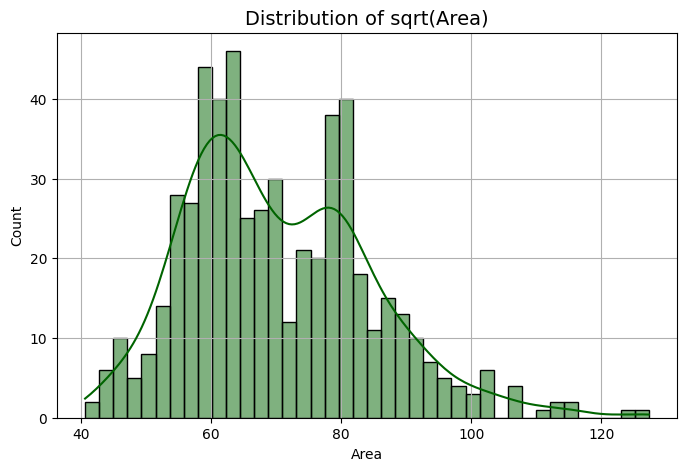

In [21]:
plt.figure(figsize=(8,5))
sns.histplot(np.sqrt(df['area']), bins=40, kde=True, color='darkgreen')
plt.title('Distribution of sqrt(Area)', fontsize=14)
plt.xlabel('Area')
plt.ylabel('Count')
plt.grid(True)
plt.show()

### ✅ In the case of area, the distribution is more symmetrical using the square root. In the case of the logarithm, the values appear to be very close together, and excessive compression may make it difficult to clearly distinguish houses with different surface areas.

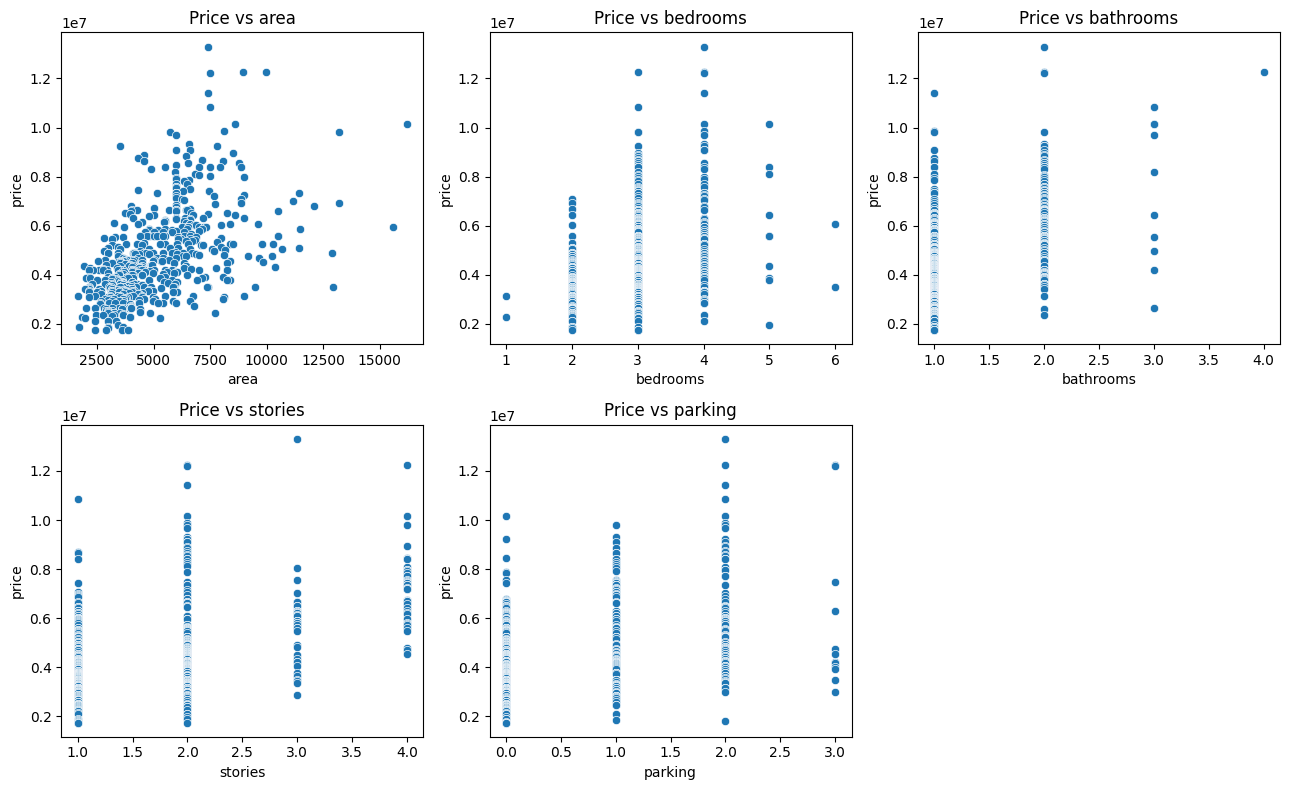

In [22]:
# Scatterplot price vs numeric vars
plt.figure(figsize=(13, 8))
for i, var in enumerate(numeric_vars, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df, x=var, y='price')
    plt.title(f'Price vs {var}')
plt.tight_layout()
plt.show()

### ➡️ Area is the numerical variable that appears to have the strongest and most visibly increasing association with price. The other variables (bedrooms, bathrooms, stories, parking) show similar, but less pronounced, patterns and greater price overlap. However, none of the numerical variables alone is sufficient to fully explain the price.

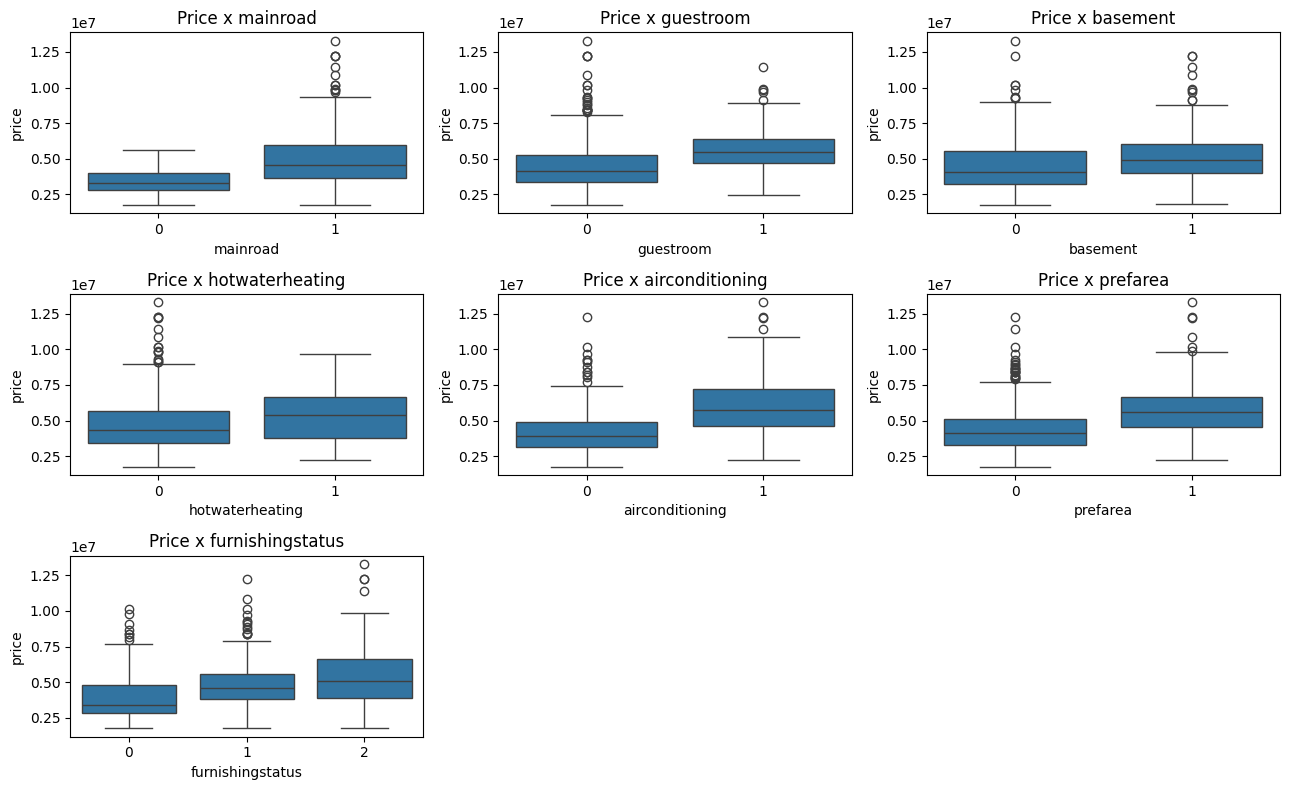

In [23]:
# Boxplot price versus categorical variables
categorical_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
plt.figure(figsize=(13, 8))
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=var, y='price', data=df)
    plt.title(f'Price x {var}')
plt.tight_layout()
plt.show()

### ➡️ These boxplots show how the presence or absence of these categorical characteristics affects the price distribution in the dataset: there are characteristics such as mainroad, guestroom, airconditioning and prefarea that tend to increase the price, while others such as basement and hotwaterheating show less evident effects.

## Showing correlation matrix
This is done for:
- Having an idea of feature–target correlations
- Detecting collinearity informs our regularization strategy and helps ensure stable, interpretable models.

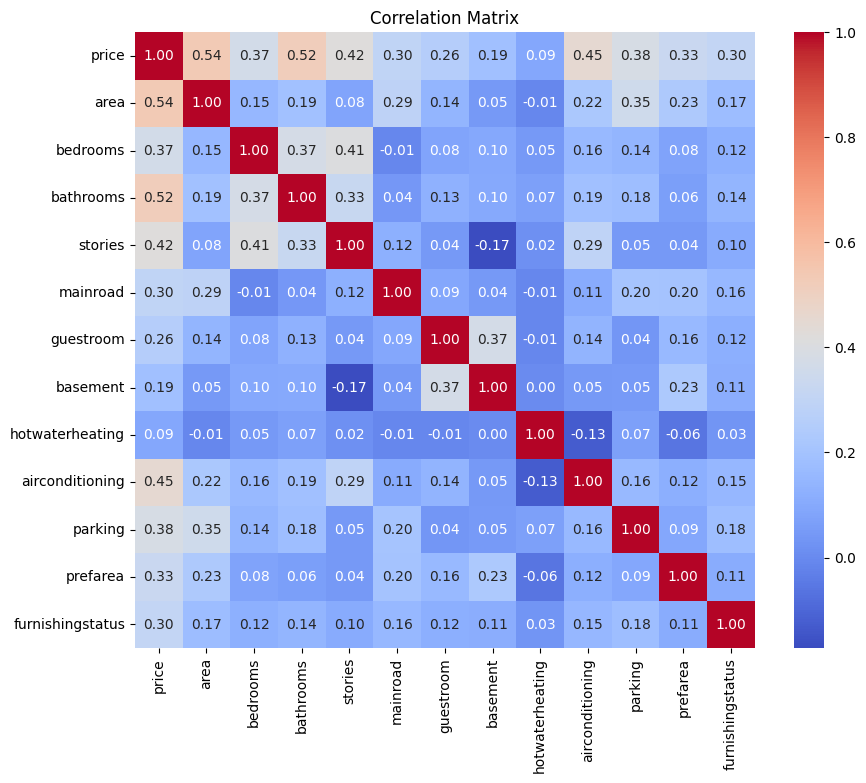

In [24]:
show_correlation_matrix(df)

## Correlation Matrix Results

- **No feature** shows a strong correlation (>|0.7|).  
- The heatmap reveals **no problematic collinearity** between features.  

### Key Correlations with `price`
- **Area:** 0.54  
- **Bathrooms:** 0.52  
- **Airconditioning:** 0.45


---



# 📈 VIF

In [25]:
# Drop target variable before computing VIF
calculate_vif(df.drop('price', axis=1))

,feature,VIF
1,bedrooms,15.293315
2,bathrooms,9.429678
0,area,8.274080
3,stories,7.886990
4,mainroad,6.871438
11,furnishingstatus,2.727003
6,basement,2.022168
9,parking,1.959942
8,airconditioning,1.748656
10,prefarea,1.486713



### The Variance Inflation Factor (VIF) is used to detect multicollinearity among numerical features. High multicollinearity can destabilize regression models and inflate the variance of coefficient estimates.



*    VIF > 10: Strong multicollinearity (problematic)
*    VIF 5–10: Moderate multicollinearity (warning)
*    VIF < 5: Low or no multicollinearity (acceptable)

### As also reported in the dataset description on Kaggle, the original dataset shows strong multicollinearity.
-  Coefficients may be unstable or difficult to interpret
-  Regularization (Ridge, Lasso, ElasticNet) is justified and recommended to stabilize the model and reduce the impact of collinearity


---








In [26]:
# Target transformations
df['price_log'] = np.log(df['price'])
df['area_sqrt'] = np.sqrt(df['area'])

In [27]:
X = df.drop(columns=['price_log', 'price', 'area'])
y = df['price_log']

In [28]:
X.head(2)

,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,area_sqrt
0,4,2,3,1,0,0,0,1,2,1,2,86.139422
1,4,4,4,1,0,0,0,1,3,0,2,94.657277


In [29]:
y

,price_log
0,16.403275
1,16.321036
2,16.321036
3,16.318175
4,16.250001
...,...
540,14.414347
541,14.384879
542,14.375126
543,14.375126


# Feature Scaling:
### Regularized models require feature scaling for stable regularization. We will use MinMaxScaler for numeric features.

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Columns to scale (numeric non-binary)
cols_to_scale = ['bedrooms', 'bathrooms', 'stories', 'parking', 'area_sqrt', 'furnishingstatus']

scaler = MinMaxScaler()

X_train_scaled_df = X_train.copy()
X_test_scaled_df = X_test.copy()

X_train_scaled_df[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled_df[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [31]:
X_train_scaled_df.head(7)

,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,area_sqrt
126,0.4,0.0,0.000000,1,0,1,0,0,0.666667,1,0.0,0.507698
363,0.2,0.0,0.000000,1,0,0,1,0,0.000000,0,0.5,0.222093
370,0.2,0.0,0.000000,1,0,0,0,1,0.666667,0,0.5,0.286197
31,0.4,0.0,1.000000,1,0,0,0,1,0.666667,0,0.5,0.496726
113,0.4,0.0,0.000000,1,0,1,0,0,0.666667,1,1.0,0.663075
222,0.2,0.0,0.000000,1,0,1,0,1,0.666667,0,0.5,0.636045
462,0.4,0.0,0.333333,0,0,1,0,0,0.000000,0,0.5,0.067571


### Evaluate simple Linear Regression

In [32]:
lr = LinearRegression()
lr.fit(X_train_scaled_df, y_train)

LinearRegression()

Train evaluation:
MSE: 912705383227.893
RMSE: 955356.155
R2 SCORE: 0.709

Test evaluation:
MSE: 1505793404196.611
RMSE: 1227107.739
R2 SCORE: 0.650




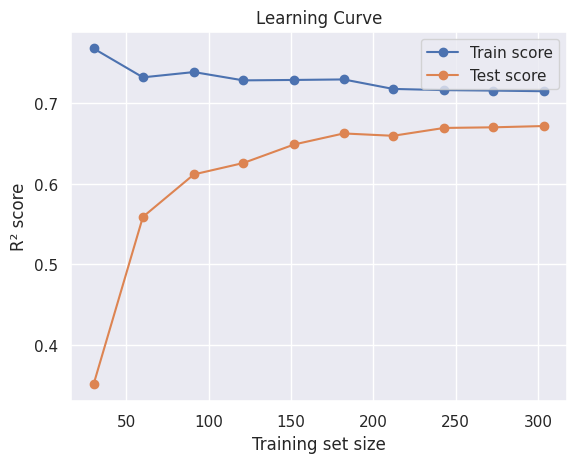

In [33]:
print('Train evaluation:')
sigma_linreg_train, linear_residues_train = evaluate(lr, X_train_scaled_df, y_train)

print('\nTest evaluation:')
sigma_linreg_test, linear_residues = evaluate(lr, X_test_scaled_df, y_test)

print('\n')
plot_learning_curve(lr, X_train_scaled_df, y_train)

The training R² score (0.709) indicates that the model explains about 71% of the variance in the training data, while the test R² score (0.650) suggests that the model explains about 65% of the variance on unseen data.
This drop in performance from train to test indicates some degree of overfitting, but the generalization gap is not extreme.

📈 The learning curves provide further insight:

- The training score decreases as the number of training samples increases, stabilizing around 0.72.

- The test score improves with more training samples and plateaus around 0.67.

There remains a visible gap between training and test scores even as the dataset grows, indicating that the model is somewhat overfitting and could benefit from regularization or more relevant features.

The relatively high values for RMSE and MSE on both train and test sets, combined with the persistent gap in the learning curves, suggest:

- The model fits the training data better than the test data, but not perfectly.

- Increasing training data slightly improves test performance, but fundamentally, the model may be too simple to fully capture the complexity of the problem, or feature engineering/regularization may be needed.

- Without regularization, linear regression can overfit if the dataset contains noise or highly correlated features, as shown by the learning curve gap.

In [34]:
# Cross-validation to check for potential overfitting
cv_results = cross_validate(lr, X_train_scaled_df, y_train, cv=5, scoring='r2', return_train_score=True)
print(f"Train CV R²: {cv_results['train_score'].mean():.3f}")
print(f"Test CV R²: {cv_results['test_score'].mean():.3f}")

Train CV R²: 0.716
Test CV R²: 0.672


➡️ The cross-validation results show a Train CV R² of 0.716 and a Test CV R² of 0.672. These values indicate good model performance and only a slight drop in predictive accuracy from training to test data, suggesting minimal overfitting. This finding is consistent with, and does not conflict with, the classical model evaluation metrics. The classical model's R² values and residual analysis similarly reflect a stable fit and reliable predictive power, reinforcing the robustness of the model across both evaluation approaches.

✅ Cross-validation thus reinforces the earlier findings: the linear model, while not perfect, shows stable performance and moderate generalization, making it a solid baseline.

---


### Define models and hyperparameters for regularized regression
- Ridge Regression Model (L2)
- Lasso Regression Model (L1)
- Elastic Net Model




In [35]:
# Ridge
ridge_model = Ridge()
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}

# Lasso
lasso_model = Lasso()
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]}

# Elastic Net
elastic_model = ElasticNet()
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 50, 100],
    'l1_ratio': [0.2, 0.5, 0.8, 0.9, 1.0]
}

In [36]:
# Evaluate Ridge Regression model using the predefined function 'evaluate_best_model'
# Pass the model name, Ridge model instance, hyperparameter grid, and scaled training and test data
ridge_best, ridge_pred, ridge_rmse, ridge_r2 = evaluate_best_model(
    "Ridge Regression",
    ridge_model,
    ridge_params,
    X_train_scaled_df, y_train, X_test_scaled_df, y_test
)
# Calculate residuals for Ridge Regression (difference between true and predicted test target values)
ridge_residues = np.exp(y_test) - ridge_pred


# Evaluate Lasso Regression model using the same evaluation function
lasso_best, lasso_pred, lasso_rmse, lasso_r2 = evaluate_best_model(
    "Lasso Regression",
    lasso_model,
    lasso_params,
    X_train_scaled_df, y_train, X_test_scaled_df, y_test
)
# Calculate residuals for Lasso Regression on the test set
lasso_residues =  np.exp(y_test) - lasso_pred


# Evaluate Elastic Net Regression model using the evaluation function
elastic_best, elastic_pred, elastic_rmse, elastic_r2 = evaluate_best_model(
    "Elastic Net Regression",
    elastic_model,
    elastic_params,
    X_train_scaled_df, y_train, X_test_scaled_df, y_test
)
# Calculate residuals for Elastic Net Regression on the test set
elastic_residues =  np.exp(y_test) - elastic_pred


Ridge Regression
Best Params: {'alpha': 0.1}
Train MSE: 912649584194.74
Test  MSE: 1503183453509.45
Train RMSE: 955326.95
Test  RMSE: 1226043.82
Train R²: 0.709
Test  R²: 0.651
Non-zero Coefficients: 12 / 12

Lasso Regression
Best Params: {'alpha': 0.001}
Train MSE: 921596829116.61
Test  MSE: 1508715265396.66
Train RMSE: 959998.35
Test  RMSE: 1228297.71
Train R²: 0.707
Test  R²: 0.650
Non-zero Coefficients: 12 / 12

Elastic Net Regression
Best Params: {'alpha': 0.001, 'l1_ratio': 0.2}
Train MSE: 914764779296.73
Test  MSE: 1499205198131.16
Train RMSE: 956433.36
Test  RMSE: 1224420.35
Train R²: 0.709
Test  R²: 0.652
Non-zero Coefficients: 12 / 12



All three regularized linear models — Ridge, Lasso, and Elastic Net — yield very similar performance, both in terms of prediction error and model generalization:

- **Ridge Regression**

  This model achieves the lowest RMSE on the test set (1,226,043.82) and a test R² of 0.651, indicating that it explains approximately 65.1% of the variance in housing prices. The training error is also well-aligned with the test error, suggesting no overfitting. All 12 coefficients are retained, confirming that all features contribute meaningfully under this mild regularization (alpha = 0.1).

- **Lasso Regression:**

  Lasso performs slightly worse than Ridge, with a higher test RMSE (1,228,297.71) and lower test R² (0.650).
  Despite using L1 regularization, no coefficients are shrunk to zero, likely because the chosen alpha (0.001) is too small to induce sparsity.
  This suggests that, in this dataset, Lasso does not offer additional benefits over Ridge.

- **Elastic Net Regression:**

  Elastic Net achieves the best R² score on the test set (0.652) and the lowest test MSE, indicating slightly better generalization compared to Ridge and Lasso.
  The combination of L1 and L2 penalties (alpha = 0.001, l1_ratio = 0.2) likely helped balance between regularization strength and feature retention.
  Again, all 12 features are kept, reinforcing that no single feature is redundant under current settings.

## Small recap on results:

- All three models generalize similarly, with **Elastic Net** performing marginally better in terms of test MSE and R².

- No significant feature elimination was observed, so Lasso did not provide sparsity.

- Regularization had limited effect overall due to the relatively balanced and well-preprocessed dataset.

- Further improvements may require exploring non-linear models or engineering additional features.

# Learning Curve

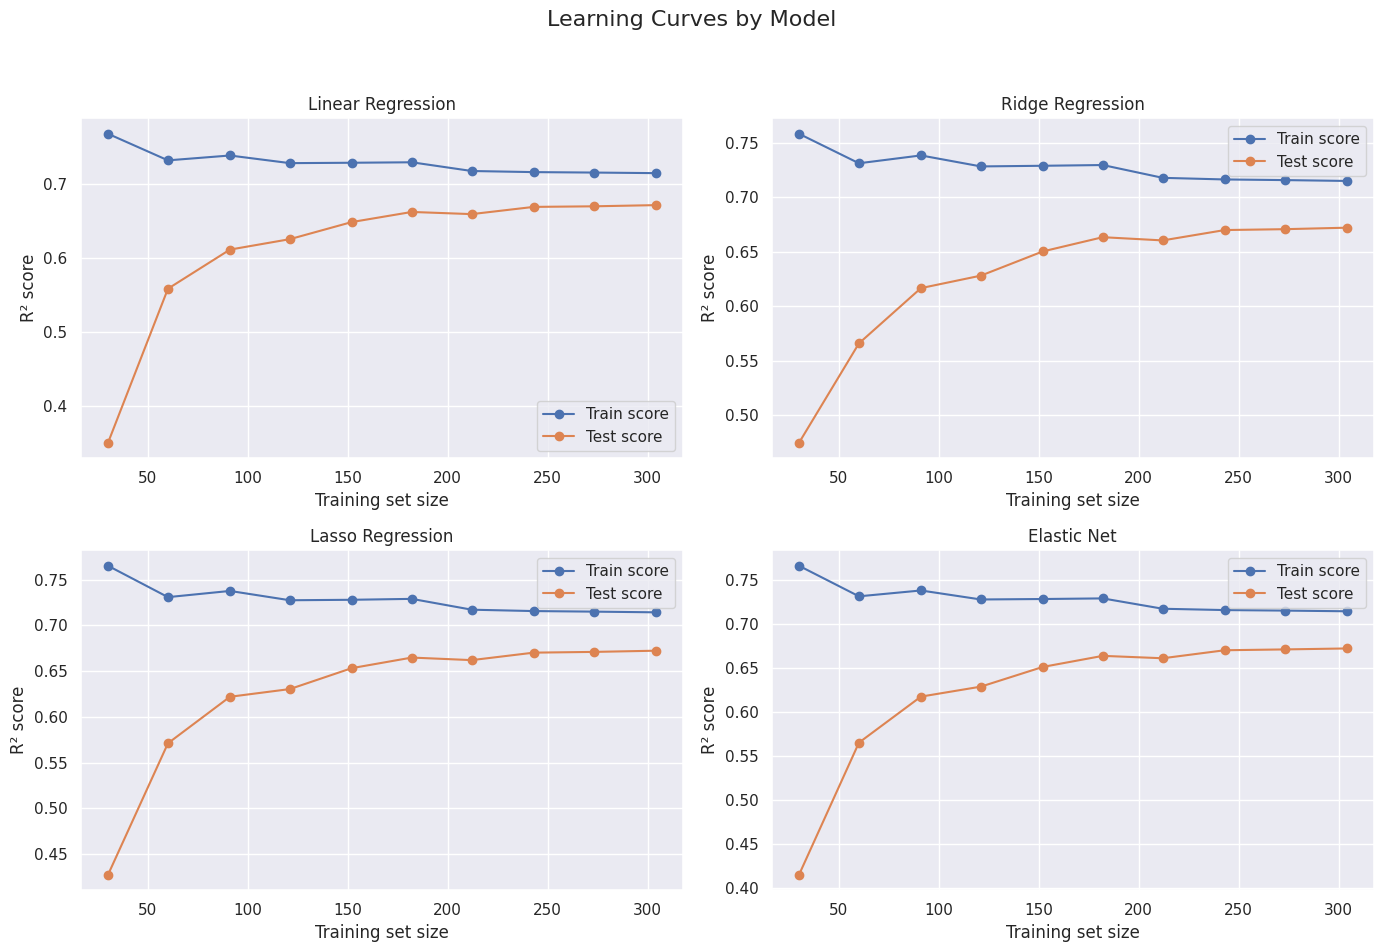

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plot_learning_curve(LinearRegression(), X_train_scaled_df, y_train, ax=axes[0, 0], title='Linear Regression')
plot_learning_curve(Ridge(alpha=0.1), X_train_scaled_df, y_train, ax=axes[0, 1], title='Ridge Regression')
plot_learning_curve(Lasso(alpha=0.001), X_train_scaled_df, y_train, ax=axes[1, 0], title='Lasso Regression')
plot_learning_curve(ElasticNet(alpha=0.001, l1_ratio=0.2), X_train_scaled_df, y_train, ax=axes[1, 1], title='Elastic Net')

plt.suptitle('Learning Curves by Model', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Learning Curves Analysis

### ✅The learning curves shown above compare the training and test performance of four linear models: Linear Regression, Ridge Regression, Lasso Regression, and Elastic Net.
### All models achieve similar results, with training R² scores around 0.71 and test R² scores near 0.65. This suggests, as already said, that all models generalize in a similar way and there is no significant overfitting or underfitting.


*   ### Ridge and Elastic Net Regression slightly improve the generalization compared to ordinary linear regression and Lasso, as shown by the marginally higher test R² scores and lower test MSE.
*   ### Lasso Regression does not shrink any coefficients to zero, implying all features are important for the model.

### Increasing the training set size reduces the gap between train and test scores for all models, reflecting stable learning and the absence of major variance issues.

### Overall, regularization has little impact on predictive performance for this dataset, indicating a relatively low risk of overfitting.

## Model evaluation summary and residual standard deviation calculation

In [39]:
# Simple Linear Regression
print(f'Residual Standard Deviation (Linear Regression): {sigma_linreg_train:.2f}')

# Ridge
y_test_real = np.exp(y_test)
sigma_ridge = residual_std(y_test_real, ridge_pred, n_features=X_test.shape[1])
print(f'Residual Standard Deviation (Ridge): {sigma_ridge:.2f}')

# Lasso
sigma_lasso = residual_std(y_test_real, lasso_pred, n_features=X_test.shape[1])
print(f'Residual Standard Deviation (Lasso): {sigma_lasso:.2f}')

# Elastic Net
sigma_elastic = residual_std(y_test_real, elastic_pred, n_features=X_test.shape[1])
print(f'Residual Standard Deviation (Elastic Net): {sigma_elastic:.2f}')

Residual Standard Deviation (Linear Regression): 972084.20
Residual Standard Deviation (Ridge): 1277731.04
Residual Standard Deviation (Lasso): 1280079.94
Residual Standard Deviation (Elastic Net): 1276039.12


### The residual standard deviation (σ̂) represents the average deviation of the predicted values from the actual values, and it reflects the typical size of prediction errors.

*   ### The Linear Regression model shows the lowest residual standard deviation (972,084), which suggests tighter fit on the training data.
*   ### Regularized models (Ridge, Lasso, Elastic Net) have slightly higher residual deviations (~1.27M), reflecting a trade-off between bias and variance.
*   ### This increase in σ̂ is expected, as regularization methods constrain model complexity to improve generalization — even if they slightly worsen training fit.

### Overall, although Linear Regression fits the training data more closely, the regularized models may generalize better by reducing overfitting risk.


In [40]:
scores_ridge = cross_val_score(ridge_best, X_train_scaled_df, y_train, scoring='r2', cv=5)
print(f'Ridge CV R² (mean): {scores_ridge.mean():.3f}')

scores_lasso = cross_val_score(lasso_best, X_train_scaled_df, y_train, scoring='r2', cv=5)
print(f'Lasso CV R² (mean): {scores_lasso.mean():.3f}')

scores_elastic = cross_val_score(elastic_best, X_train_scaled_df, y_train, scoring='r2', cv=5)
print(f'Elastic Net CV R² (mean): {scores_elastic.mean():.3f}')

Ridge CV R² (mean): 0.672
Lasso CV R² (mean): 0.672
Elastic Net CV R² (mean): 0.673


### These cross-validated R² results for the Ridge, Lasso, and Elastic Net models indicate good overall predictive ability:

*   ### All three models have very similar R² values, around 0.672-0.673.
*   ### An R² of around 0.67 means that the models explain approximately 67% of the data variability in the training sample.

### All 3 models perform very similarly and well, with no major differences between them, demonstrating that all three are good at capturing the relationship between predictors and response in the dataset.

# 📈Performance Comparison Visualization
### Comparison chart of RMSE and R² on models

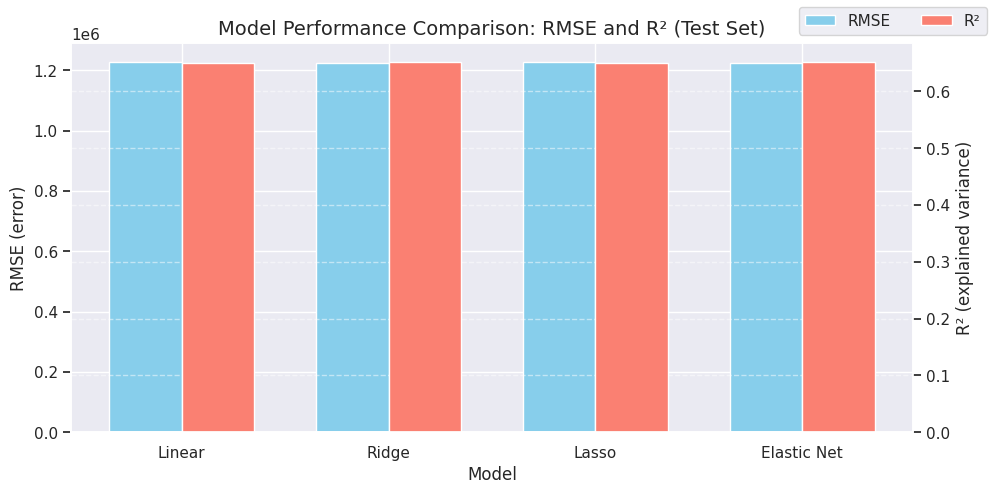

In [41]:
# Model names
models = ['Linear', 'Ridge', 'Lasso', 'Elastic Net']

# RMSE values (test set)
rmse_values = [1227107.739, 1226043.82, 1228297.71, 1224420.35]

# R² values (test set)
r2_values = [0.650, 0.651, 0.650, 0.652]

# Set column width and positions
x = np.arange(len(models))
width = 0.35

# Create figure and side-by-side axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar chart for RMSE
bar1 = ax1.bar(x - width/2, rmse_values, width, label='RMSE', color='skyblue')
ax1.set_ylabel('RMSE (error)', fontsize=12)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_title('Model Performance Comparison: RMSE and R² (Test Set)', fontsize=14)
ax1.tick_params(axis='y')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# Create second y-axis for R²
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, r2_values, width, label='R²', color='salmon')
ax2.set_ylabel('R² (explained variance)', fontsize=12)
ax2.tick_params(axis='y')

# Manually create combined legend
fig.legend(handles=[bar1, bar2], labels=['RMSE', 'R²'], loc='upper right', ncol=2)
plt.subplots_adjust(top=0.85)

# Show the grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### We observe that:

*   ### The RMSE values (blue bars) are very similar across the four models (Linear, Ridge, Lasso, Elastic Net), all around approximately 1.22 million. Since RMSE measures the average squared prediction error, such similar values indicate that the predictive performances of the models are essentially equivalent on the test set.

*   ### The R² values (red bars) are also close to each other, around 0.65 for all models. R² represents the proportion of variance explained by the model, so similar values show that all models explain a comparable amount of variability in the data.

### In summary, the four models show nearly indistinguishable performance in terms of both predictive accuracy and explanatory power. Although the dataset exhibits strong multicollinearity, the use of regularization (in Ridge, Lasso, and Elastic Net) did not significantly improve predictive performance over the simple linear model. This could be due to various factors, such as the choice of regularization parameters or the inherent nature of the data and variability.

# Distribution of residuals (for each model)

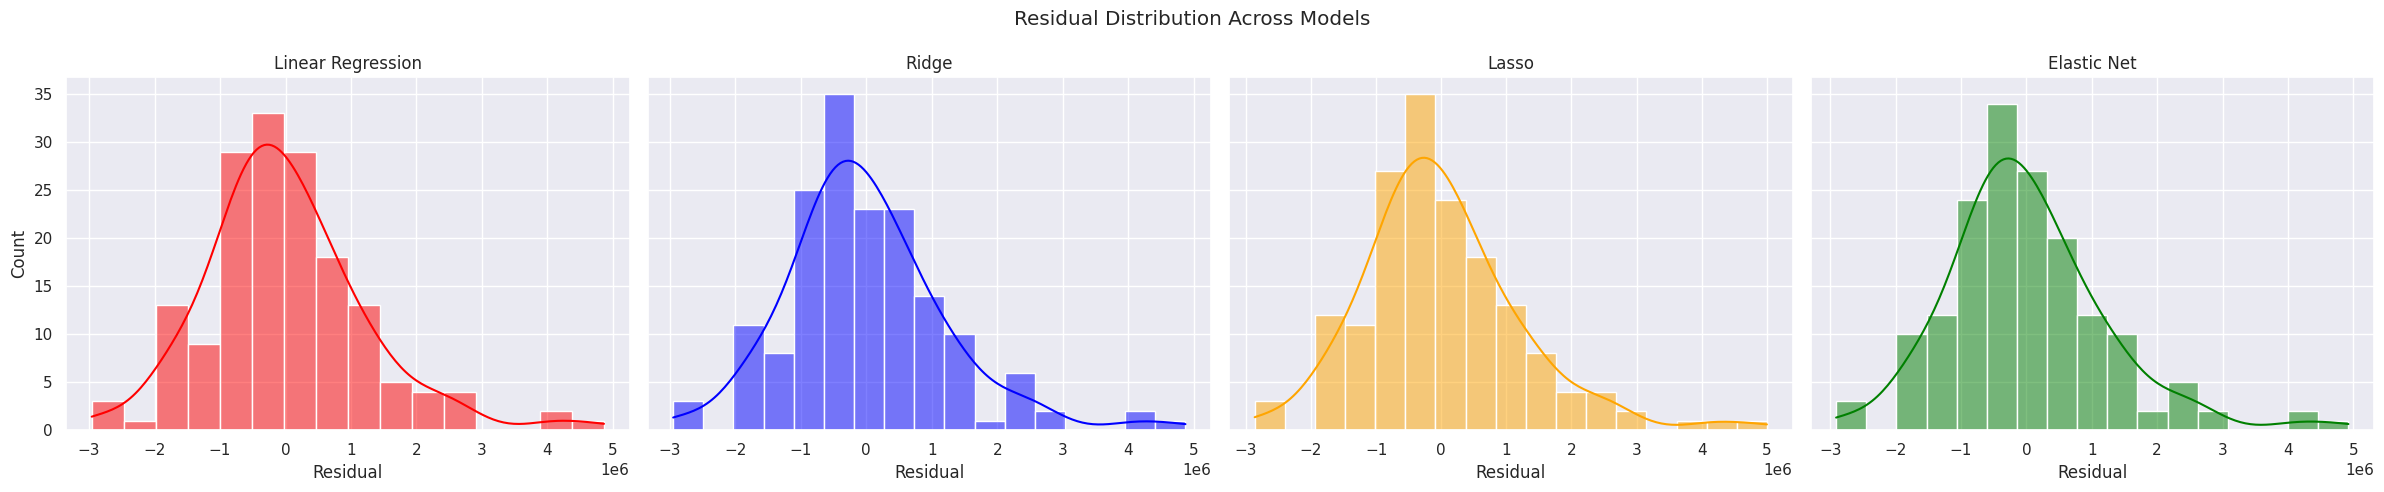

In [42]:
# Residual distribution comparison for Ridge, Lasso and Elastic Net
fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)

sns.histplot(linear_residues, kde=True, ax=axes[0], color='red')
axes[0].set_title('Linear Regression')
axes[0].set_xlabel('Residual')

sns.histplot(ridge_residues, kde=True, ax=axes[1], color='blue')
axes[1].set_title('Ridge')
axes[1].set_xlabel('Residual')

sns.histplot(lasso_residues, kde=True, ax=axes[2], color='orange')
axes[2].set_title('Lasso')
axes[2].set_xlabel('Residual')

sns.histplot(elastic_residues, kde=True, ax=axes[3], color='green')
axes[3].set_title('Elastic Net')
axes[3].set_xlabel('Residual')

plt.suptitle('Residual Distribution Across Models')
plt.tight_layout()
plt.grid(True)
plt.show()

### The residuals for all the models are approximately centered around zero and follow a roughly normal distribution. This indicates that the models do not exhibit systematic bias in predictions and the errors are symmetrically distributed. Ridge and Elastic Net show slightly tighter residual distributions compared to Lasso, suggesting potentially better fit and smaller prediction errors. Overall, the residual distributions support the adequacy of the models.

# Residuals versus Actual Prices: check for heteroscedasticity

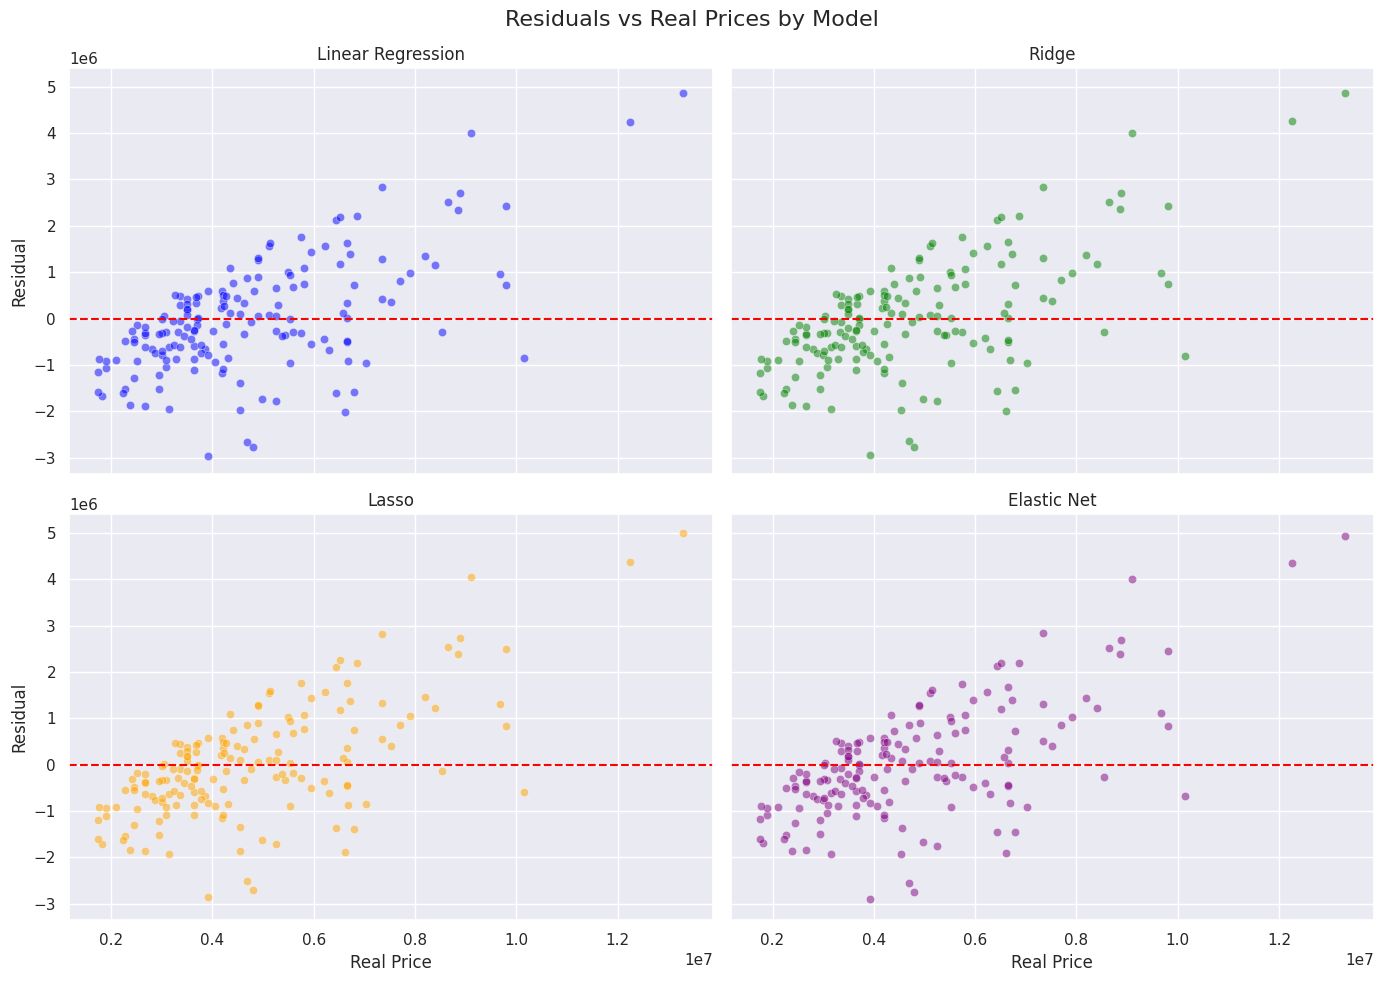

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

sns.scatterplot(x=np.exp(y_test), y=linear_residues, ax=axes[0, 0], color='blue', alpha=0.5)
axes[0, 0].set_title('Linear Regression')
axes[0, 0].axhline(0, linestyle='--', color='red')

sns.scatterplot(x=np.exp(y_test), y=ridge_residues, ax=axes[0, 1], color='green', alpha=0.5)
axes[0, 1].set_title('Ridge')
axes[0, 1].axhline(0, linestyle='--', color='red')

sns.scatterplot(x=np.exp(y_test), y=lasso_residues, ax=axes[1, 0], color='orange', alpha=0.5)
axes[1, 0].set_title('Lasso')
axes[1, 0].axhline(0, linestyle='--', color='red')

sns.scatterplot(x=np.exp(y_test), y=elastic_residues, ax=axes[1, 1], color='purple', alpha=0.5)
axes[1, 1].set_title('Elastic Net')
axes[1, 1].axhline(0, linestyle='--', color='red')

for ax in axes.flatten():
    ax.set_xlabel('Real Price')
    ax.set_ylabel('Residual')
    ax.grid(True)

plt.suptitle('Residuals vs Real Prices by Model', fontsize=16)
plt.tight_layout()
plt.show()

### The residual plot reveals some important insights about the model’s performance. Notably, there is a clear funnel shape in the distribution of residuals: as the actual price values increase, the residuals—meaning the differences between predicted and actual prices—also increase in magnitude. This pattern indicates heteroscedasticity, which means the variance of the errors is not constant across the range of prices.

### In practical terms, this suggests that the linear regression model struggles to capture the full complexity across the entire price range, especially for higher prices where prediction errors become larger and more spread out. The non-random “V” or funnel pattern in the residuals further confirms that the assumption of equal error variance—key to classic linear regression—is violated here.

### This violation can affect the reliability of the standard errors and hypothesis tests derived from the model, and it signals that we might need to consider alternative modeling approaches or transformations to better handle this variability.

# Final considerations:

### The model performs well in terms of average accuracy and residual distribution, but the heteroskedasticity highlighted by the residuals vs. actual values graph indicates the need for further improvements or adjustments to meet the basic assumptions of linear regression and ensure inferential validity.